In [55]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [81]:
def load_data(dataset_dir):
    data = []
    labels = []
    for s_id in range(1, 41):
        subject_folder = f's{s_id}'
        subject_path = os.path.join(dataset_dir, subject_folder)
        image_files = os.listdir(subject_path)
        for image_file in image_files:
            image_path = os.path.join(subject_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image_vector = image.reshape(-1)
            data.append(image_vector)
            labels.append(s_id)
    data_matrix = np.array(data)
    label_vector = np.array(labels)
    return data_matrix, label_vector

In [82]:
def split_data(data_matrix, label_vector, test_size, random_state=None):
    D_train, D_test, y_train, y_test = train_test_split(data_matrix, label_vector, test_size=test_size, random_state=42)
    return D_train, D_test, y_train, y_test

In [101]:
def perform_pca_knn(D_train, D_test, y_train, y_test, alpha_values, k_values):
    accuracy_dict = {alpha: {k: None for k in k_values} for alpha in alpha_values}
    mean = np.mean(D_train, axis=0)
    centered_data = D_train - mean
    cov_matrix = (1 / (D_train.shape[0] - 1)) * (centered_data.T @ centered_data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    for alpha in alpha_values:
        for k in k_values:
            knn_classifier = KNeighborsClassifier(n_neighbors=k, weights='distance')
            total_variance = np.sum(eigenvalues)
            explained_variance = 0
            r = 0
            for eigenvalue in eigenvalues:
                explained_variance += eigenvalue
                if explained_variance / total_variance >= alpha:
                    break
                r += 1
            top_eigenvectors = eigenvectors[:, :r]
            X_train_pca = D_train @ top_eigenvectors
            X_test_pca = D_test @ top_eigenvectors
            knn_classifier.fit(X_train_pca, y_train)
            y_pred = knn_classifier.predict(X_test_pca)
            accuracy = accuracy_score(y_test, y_pred)
            accuracy_dict[alpha][k] = accuracy
            print(f"Alpha = {alpha}, Classification Accuracy = {accuracy}, KNN = {k}, R = {r}")
    return accuracy_dict

In [102]:
def plot_accuracy_vs_alpha(alpha_values, k_values, accuracy_dict):
    for k in k_values:
        accuracies = [accuracy_dict[alpha][k] for alpha in alpha_values]
        plt.plot(alpha_values, accuracies, marker='o', label=f'K={k}')
    plt.title('Accuracy vs. Alpha Values with PCA')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.legend(title='Number of Neighbors')
    plt.grid(True)
    plt.show()

In [103]:
def plot_accuracy_vs_k(alpha_values, k_values, accuracy_dict):
    for alpha in alpha_values:
        plt.plot(k_values, [accuracy_dict[alpha][k] for k in k_values], marker='o', label=f'Alpha = {alpha}')
    plt.xlabel('K Values')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. K for Different Alpha Values')
    plt.legend(title='Alpha')
    plt.grid(True)
    plt.show()

In [104]:
dataset_dir = 'archive'
data_matrix, label_vector = load_data(dataset_dir)
#-------------------odd-even--------------------------
total_samples = data_matrix.shape[0]
odd_indices = [i for i in range(total_samples) if i % 2 != 0]
even_indices = [i for i in range(total_samples) if i % 2 == 0]
test_size = len(odd_indices) / total_samples
#D_train, D_test, y_train, y_test = split_data(data_matrix, label_vector, test_size)
#-----------------------------------------------------

#----------------------70-30---------------------------
D_train, D_test, y_train, y_test = split_data(data_matrix, label_vector, 0.3)

In [105]:
alpha_values = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7]
accuracy_dict = perform_pca_knn(D_train, D_test, y_train, y_test, alpha_values, k_values)

Alpha = 0.8, Classification Accuracy = 0.9333333333333333, KNN = 1, R = 40
Alpha = 0.8, Classification Accuracy = 0.9166666666666666, KNN = 3, R = 40
Alpha = 0.8, Classification Accuracy = 0.9, KNN = 5, R = 40
Alpha = 0.8, Classification Accuracy = 0.875, KNN = 7, R = 40
Alpha = 0.85, Classification Accuracy = 0.9416666666666667, KNN = 1, R = 59
Alpha = 0.85, Classification Accuracy = 0.9166666666666666, KNN = 3, R = 59
Alpha = 0.85, Classification Accuracy = 0.9, KNN = 5, R = 59
Alpha = 0.85, Classification Accuracy = 0.85, KNN = 7, R = 59
Alpha = 0.9, Classification Accuracy = 0.9333333333333333, KNN = 1, R = 92
Alpha = 0.9, Classification Accuracy = 0.9166666666666666, KNN = 3, R = 92
Alpha = 0.9, Classification Accuracy = 0.8916666666666667, KNN = 5, R = 92
Alpha = 0.9, Classification Accuracy = 0.85, KNN = 7, R = 92
Alpha = 0.95, Classification Accuracy = 0.95, KNN = 1, R = 148
Alpha = 0.95, Classification Accuracy = 0.9416666666666667, KNN = 3, R = 148
Alpha = 0.95, Classificatio

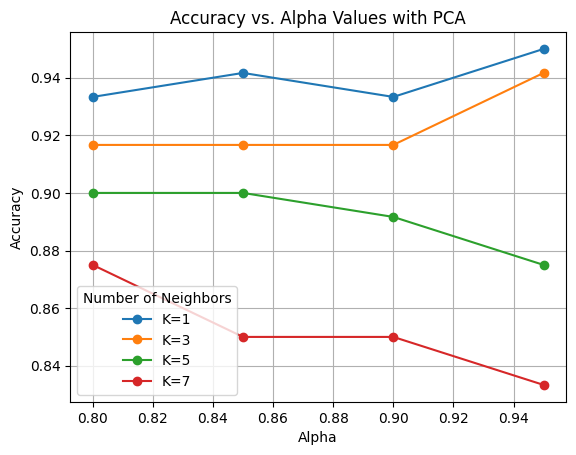

In [106]:
plot_accuracy_vs_alpha(alpha_values, k_values, accuracy_dict)

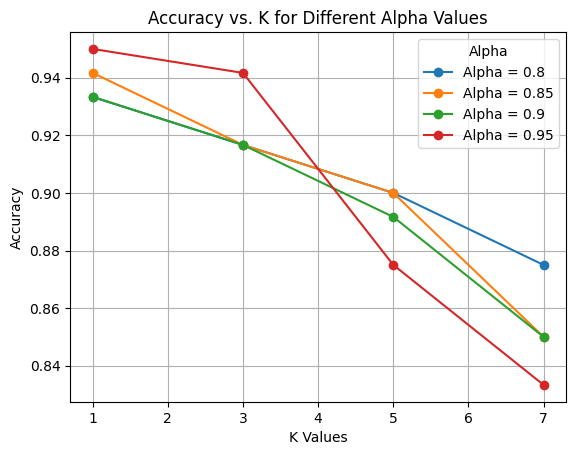

In [107]:
plot_accuracy_vs_k(alpha_values, k_values, accuracy_dict)